# Study beam impact point as a function of beam position


In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats
from scipy.spatial.transform import Rotation as transform_rotation


from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3, BEAM_CONFIG_4, FAST_BEAM_CONFIG_1, BASE_BEAM_SET
from ghosts.geom_configs import GEOM_CONFIG_0, GEOM_CONFIG_1, GEOM_CONFIG_2

from ghosts.camera import build_camera, show_camera

plt.rcParams['font.size']=12

## Build a telescope

In [3]:
# Second CCOB like geometry, i.e. lenses + filters
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_with_filter.yaml")
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")
# telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_aligned.yaml")
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_aligned_with_filter.yaml")
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_v0.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope, coating='smart',
                                    r_frac=[0.004, 0.04, 0.15])

0

In [4]:
# check the position of L1 apex
l1_entrance = tweak_optics.get_optics_position_z(telescope, "L1_entrance")
focal_plane = tweak_optics.get_optics_position_z(telescope, "Detector")
print(f'L1 entrance z is {l1_entrance:.6f}')
print(f'Focal plane z is {focal_plane:.6f}')
print(f'Distance from L1 entrance to Focal plane is {focal_plane-l1_entrance:.6f}')


L1 entrance z is 3.395712
Focal plane z is 4.427801
Distance from L1 entrance to Focal plane is 1.032089


## Define rotation from (u, b) to Euler angles

In [5]:
# function to build a config from motor angles (u, b)
from scipy.spatial.transform import Rotation as transform_rotation

def config_from_angles(beam_config, u, b):
    """ Point a beam configuration to given b and u CCOB motor angles

    Email from Andy:
    - Check that U=0, B rotates the Y axis, B>0 -> +X, B<0 -> -X
    - Check that U>0 rotates around -Z in the right-handed sense.

    Euler angles in extrinsic rotations
    https://en.wikipedia.org/wiki/Euler_angles#Conventions_by_extrinsic_rotations

    Parameters
    ----------
    beam_config : `ghost.beam_config`
        a beam configuration as a dictionnary
    u : `float`
        the value of the rotation angle in degrees around "Z" (when b=0)
    b : `float`
        the value of the rotation angle in degrees around "X" (when u=0)

    Returns
    -------
    new_beam : `ghost.beam_config`
        a new beam configuration corresponding to CCOB motor set as (u, b) angles
    """
    # copy input beam configuration
    new_beam = copy.copy(beam_config)
    rot = transform_rotation.from_euler('zxy', [u, 0., b], degrees=True)
    eulers = rot.as_euler('ZXY', degrees=True)
    new_beam['z_euler'] = eulers[0]
    new_beam['x_euler'] = eulers[1]
    new_beam['y_euler'] = eulers[2]
    return new_beam


Direct path is number 28
  central impact point is (0.070099, -0.000042)
  transmission is 0.7647

Maximum expected flux is 0.7647
Maximum bin content is 77.5114


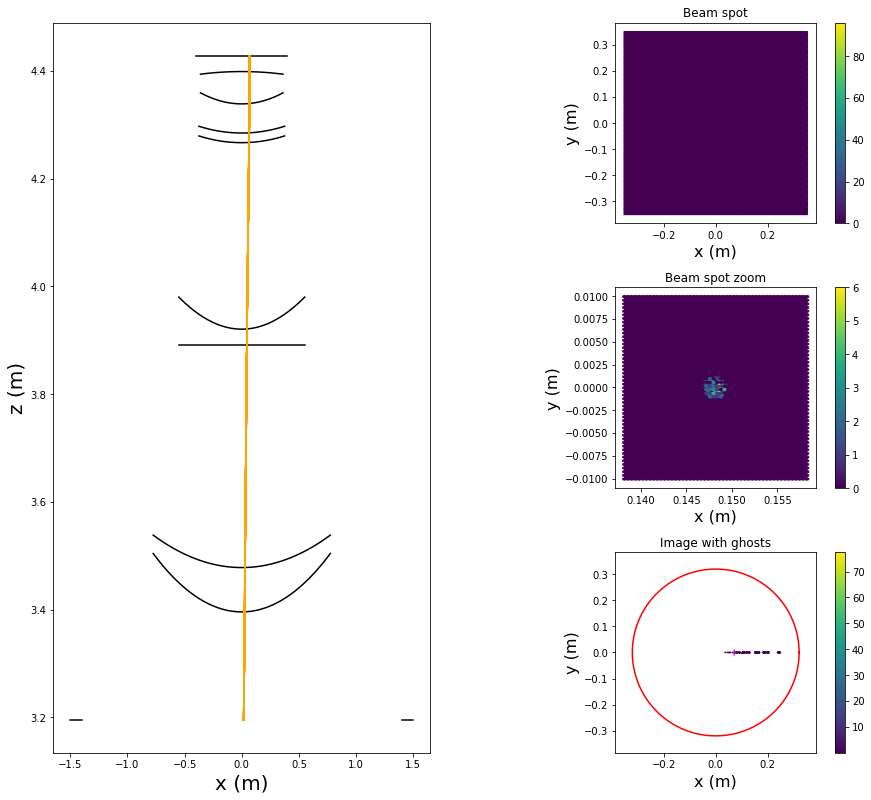

0

In [6]:
# Check that U=0, B rotates the Y axis, B>0 -> +X
center = copy.deepcopy(BEAM_CONFIG_0)
center['n_photons'] = 100

test_beam = config_from_angles(center, u=0, b=2.5)

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_beam)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

   beam_id            wl  n_photons   radius  x_offset  y_offset  z_offset  \
0        0  5.000000e-07       1000  0.00125       0.0         0  2.797473   
1        1  5.000000e-07       1000  0.00125       0.0         0  2.797473   
2        2  5.000000e-07       1000  0.00125       0.0         0  2.797473   
3        3  5.000000e-07       1000  0.00125       0.0         0  2.797473   
4        4  5.000000e-07       1000  0.00125       0.0         0  2.797473   

   z_euler  y_euler  x_euler  
0      0.0      0.0      0.0  
1      0.0      2.5      0.0  
2      0.0      5.0      0.0  
3      0.0      7.5      0.0  
4     30.0      0.0      0.0  


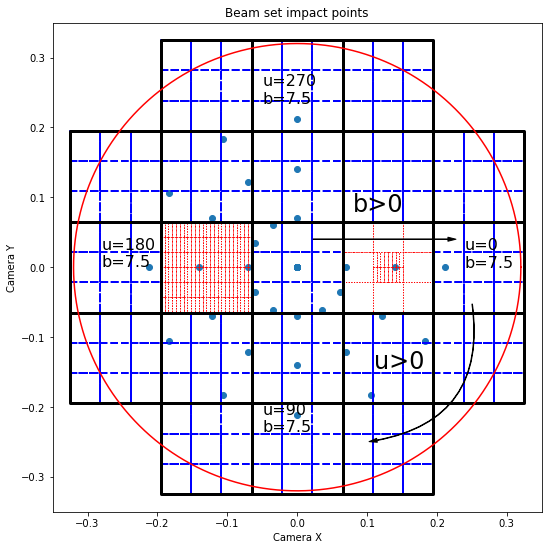

In [7]:
# Check that U=0, B rotates the Y axis, B>0 -> +X, B<0 -> -X
# Check that U>0 rotates around -Z in the right-handed sense
# Check rotation around the clock
beam_set = []
i = 0
for u in range(0, 271, 30):
    for b in np.arange(0, 7.6, 2.5):
        center = copy.deepcopy(BEAM_CONFIG_0)
        beam_conf = config_from_angles(center, u=u, b=b)
        beam_conf['beam_id'] = i
        beam_set.append(beam_conf)
        i = i + 1

# show beam set content
beam_grid = beam.concat_dicts(beam_set)
print(beam_grid.head())

# simulate
impacts_df = simulator.simulate_impact_points_for_beam_set(telescope, beam_set)

# plot
plotter.plot_impact_points_full_frame(impacts_df)
camera = build_camera()
show_camera(plt.gca(), camera)

# some notes
plt.gca().text(0.24, 0.0, "u=0\nb=7.5", fontsize=16)
plt.gca().text(-0.05, -0.235, "u=90\nb=7.5", fontsize=16)
plt.gca().text(-0.28, 0.001, "u=180\nb=7.5", fontsize=16)
plt.gca().text(-0.05, 0.235, "u=270\nb=7.5", fontsize=16)

# rotation sense
import matplotlib.patches as patches
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")
# rotation for b>0
barrow = patches.FancyArrowPatch((0.02, 0.04), (0.23, 0.04), **kw)
plt.gca().text(0.08, 0.08, "b>0", fontsize=24)
plt.gca().add_patch(barrow)
# rotation for u>0
uarrow = patches.FancyArrowPatch((0.25, -0.05), (0.10, -0.25),
                                connectionstyle="arc3,rad=-.5", **kw)
plt.gca().text(0.11, -0.145, "u>0", fontsize=24)
plt.gca().add_patch(uarrow)

## Define functions to read input configuration files in cfg and txt format, and functions to build configurations from configurations

In [8]:
# Read official configs for step 9
def read_ccob_config_cfg(file_path):
    col_names = 'CCOBBPOS CCOBUPOS CCOBXPOS CCOBYPOS darktime expose lambda rebs CCOBBCAM CCOBUCAM CCOBXCAM CCOBYCAM id sens target_phot_per_pix total_phots'.split(' ')
    tg = pd.read_csv('../data/rband_step9_test_configs.txt', delim_whitespace=True,
                    header=None, names=col_names, engine="python")    # convert id to int
    tg['id'] = tg['id'].apply(int, base=16)
    # convert string to floats
    f_cols = 'CCOBBPOS CCOBUPOS CCOBXPOS CCOBYPOS darktime expose lambda CCOBBCAM CCOBUCAM CCOBXCAM CCOBYCAM target_phot_per_pix total_phots'.split(' ')
    for col in f_cols:
        tg[col] = tg[col].astype(float)    
    return tg

def build_beam_config_cfg(df, id):
    cc = df[df['id']==id]
    conf_0 = copy.deepcopy(BEAM_CONFIG_0)
    u = cc['CCOBUCAM'].values[0]
    b = cc['CCOBBCAM'].values[0]
    beam_conf = config_from_angles(conf_0, u, b)
    beam_conf['beam_id'] = cc['id'].values[0]
    beam_conf['wl'] = cc['lambda'].values[0]
    beam_conf['n_photons'] = 1000
    beam_conf['x_offset'] = cc['CCOBXCAM'].values[0]/1000.
    beam_conf['y_offset'] = cc['CCOBYCAM'].values[0]/1000.
    beam_conf['z_offset'] = l1_entrance - 0.200 # 2.797472
    return beam_conf

def read_ccob_config_txt(file_path):
    # define headers
    col_names = 'x y u b lambda sens rebs id expose'.split(' ')
    # ingest
    tg = pd.read_csv(file_path, sep=" ", header=None, names=col_names)
    # strip useless strings    
    for col in col_names:
        tg[col] = tg[col].str.strip(f'{col}=')
    # convert id to int
    tg['id'] = tg['id'].apply(int, base=16)
    # convert string to floats
    f_cols = 'x y u b lambda expose'.split(' ')
    for col in f_cols:
        tg[col] = tg[col].astype(float)    
    return tg

def build_beam_config_txt(df, id):
    cc = df[df['id']==id]
    conf_0 = copy.deepcopy(BEAM_CONFIG_0)
    u = cc['u'].values[0]
    b = cc['b'].values[0]
    beam_conf = config_from_angles(conf_0, u, b)
    beam_conf['beam_id'] = cc['id'].values[0]
    beam_conf['wl'] = cc['lambda'].values[0]    
    beam_conf['n_photons'] = 1000
    beam_conf['x_offset'] = cc['x'].values[0]/1000.
    beam_conf['y_offset'] = cc['y'].values[0]/1000.
    beam_conf['z_offset'] = l1_entrance - 0.200 # 2.797472
    return beam_conf

def get_ccd(ccd, df):
    return df[(df['sens']==ccd)]

def build_beam_set_cfg(df):
    beam_set = [build_beam_config_cfg(df, id) for id in df['id'].to_list()]
    return beam_set

def build_beam_set_txt(df):
    beam_set = [build_beam_config_txt(df, id) for id in df['id'].to_list()]
    return beam_set


## First read the simplified text version of the configurations file

In [9]:
# First read Andy's text version of step 9 configurations file
tg = read_ccob_config_txt('../data/rband_step9_20221130.txt')
tg.head() 

,x,y,u,b,lambda,sens,rebs,id,expose
0,162.53,204.27,9.8195,-13.5909,542.0,R14_S11,R14/Reb1,5003,0.1
1,162.53,204.27,74.5278,15.7781,542.0,R41_S11,R41/Reb1,5004,0.1
2,162.53,204.27,96.0895,15.3464,542.0,R31_S11,R31/Reb1,312,0.1
3,162.53,204.27,116.1259,16.9071,542.0,R21_S11,R21/Reb1,5006,0.1
4,162.53,204.27,131.1529,19.8851,542.0,R11_S11,R11/Reb1,5007,0.1


In [10]:
# Select a bunch of interesting configuration
r22_s11 = get_ccd('R22_S11', tg)
r11_s11 = get_ccd('R11_S11', tg)
r33_s11 = get_ccd('R33_S11', tg)
r22_s11.head(10)

,x,y,u,b,lambda,sens,rebs,id,expose
51,274.82,288.34,133.6250,18.1894,542.000,R22_S11,R22/Reb1,5054,0.1
78,90.34,421.14,102.1062,19.5603,542.000,R22_S11,R22/Reb1,5081,0.1
106,-239.34,-326.99,126.2036,-18.4832,701.000,R22_S11,R22/Reb1,5109,0.1
118,-149.80,505.67,73.4983,23.5112,701.000,R22_S11,R22/Reb1,5121,0.1
128,-349.58,-123.23,160.5813,-17.0013,701.000,R22_S11,R22/Reb1,5131,0.1
174,-448.17,-18.01,177.6999,-20.3037,659.288,R22_S11,R22/Reb1,5177,0.1
187,-309.96,53.14,9.7285,14.5433,554.615,R22_S11,R22/Reb1,5190,0.1
200,-286.69,-307.44,133.0004,-19.1242,587.004,R22_S11,R22/Reb1,5203,0.1
224,364.46,-167.28,24.6543,-18.3036,610.083,R22_S11,R22/Reb1,5227,0.1
257,-348.63,268.35,37.5857,19.9461,555.812,R22_S11,R22/Reb1,5260,0.1


In [11]:
# Map to a ghosts beam config
r22_s11_beam_set = build_beam_set_txt(r22_s11)
r11_s11_beam_set = build_beam_set_txt(r11_s11)
r33_s11_beam_set = build_beam_set_txt(r33_s11)

In [12]:
r22_s11_beam_set[0]

{'beam_id': 5054,
 'wl': 542.0,
 'n_photons': 1000,
 'radius': 0.00125,
 'x_offset': 0.27482,
 'y_offset': 0.28834,
 'z_offset': 3.195711882,
 'z_euler': 135.0930170603762,
 'y_euler': -12.772939514501296,
 'x_euler': 13.059508444047}

0

/home/bregeon/data/Soft/miniconda3/envs/ghosts/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


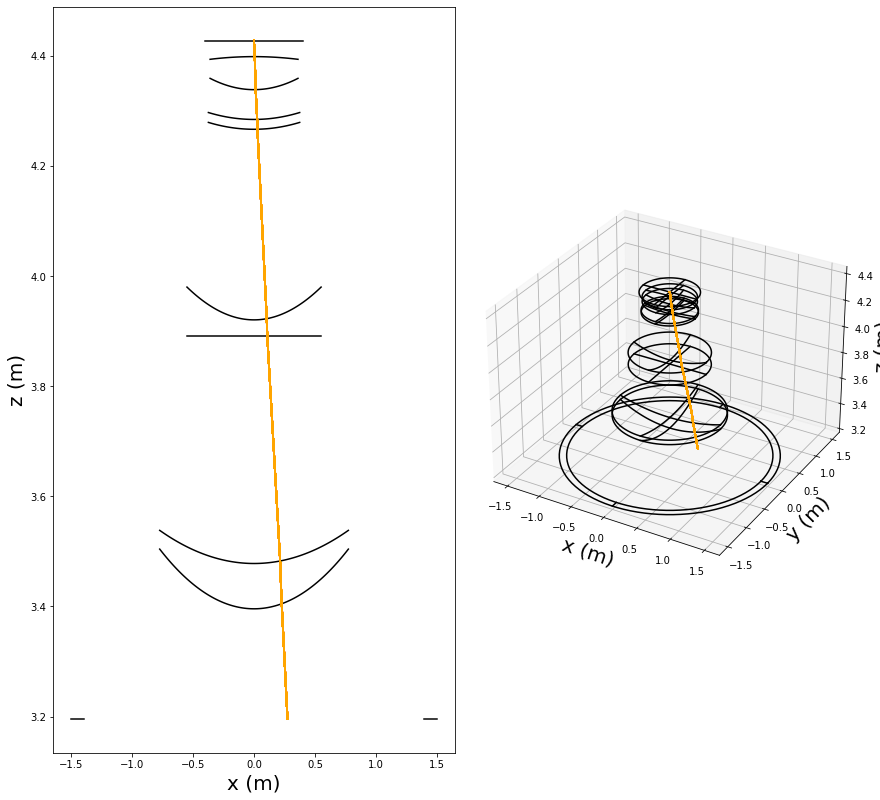

In [13]:
# Run simulation with th e first selected configuration
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=r22_s11_beam_set[0])
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup_3d(telescope, simulation)

In [14]:
impacts_r22_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r22_s11_beam_set)

<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

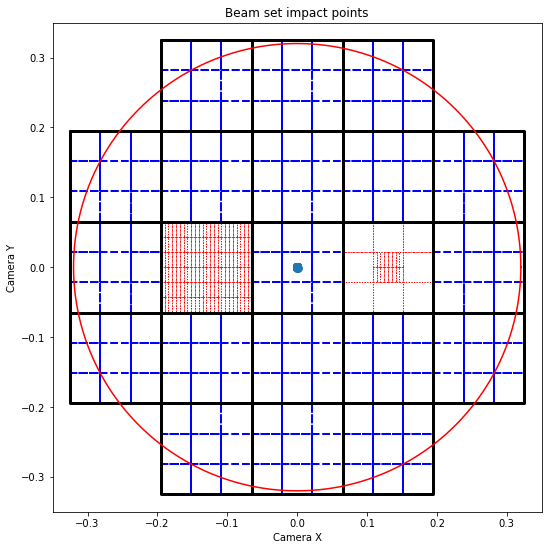

In [15]:
plotter.plot_impact_points_full_frame(impacts_r22_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

In [16]:
impacts_r22_s11

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,x_spot,y_spot,beam_dist_to_center,spot_dist_to_center,convergence,displacement
5054,5054,542.000,1000,0.00125,0.27482,0.28834,3.195712,135.093017,-12.772940,13.059508,-0.000684,-0.000729,0.398329,0.000999,0.002509,-0.397330
5081,5081,542.000,1000,0.00125,0.09034,0.42114,3.195712,102.823800,-4.261564,19.108192,-0.000273,-0.001218,0.430721,0.001249,0.002899,-0.429472
5109,5109,701.000,1000,0.00125,-0.23934,-0.32699,3.195712,127.660880,11.168734,-14.821948,0.000603,0.000834,0.405224,0.001029,0.002539,-0.404195
5121,5121,701.000,1000,0.00125,-0.14980,0.50567,3.195712,72.096118,7.044430,22.488438,0.000598,-0.002040,0.527392,0.002126,0.004031,-0.525266
5131,5131,701.000,1000,0.00125,-0.34958,-0.12323,3.195712,161.370185,16.085569,-5.578632,0.000793,0.000283,0.370664,0.000842,0.002271,-0.369822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7708,7708,659.511,1000,0.00125,-0.04739,-0.52573,3.195712,95.615187,2.238765,-23.429687,0.000198,0.002153,0.527862,0.002162,0.004096,-0.525700
7718,7718,683.935,1000,0.00125,-0.19926,0.32077,3.195712,56.951148,9.333929,14.633028,0.000475,-0.000758,0.377621,0.000895,0.002369,-0.376727
7726,7726,628.948,1000,0.00125,-0.11512,-0.48754,3.195712,104.332279,5.424827,-21.819739,0.000434,0.001793,0.500947,0.001844,0.003682,-0.499102
7733,7733,646.232,1000,0.00125,0.17679,-0.38423,3.195712,64.020494,-8.296681,-17.413001,-0.000502,0.001068,0.422951,0.001180,0.002790,-0.421771


x_spot is at -22 +/- 1009 mu (dist=4420 mu)
y_spot is at -52 +/- 974 mu (dist=4458 mu)


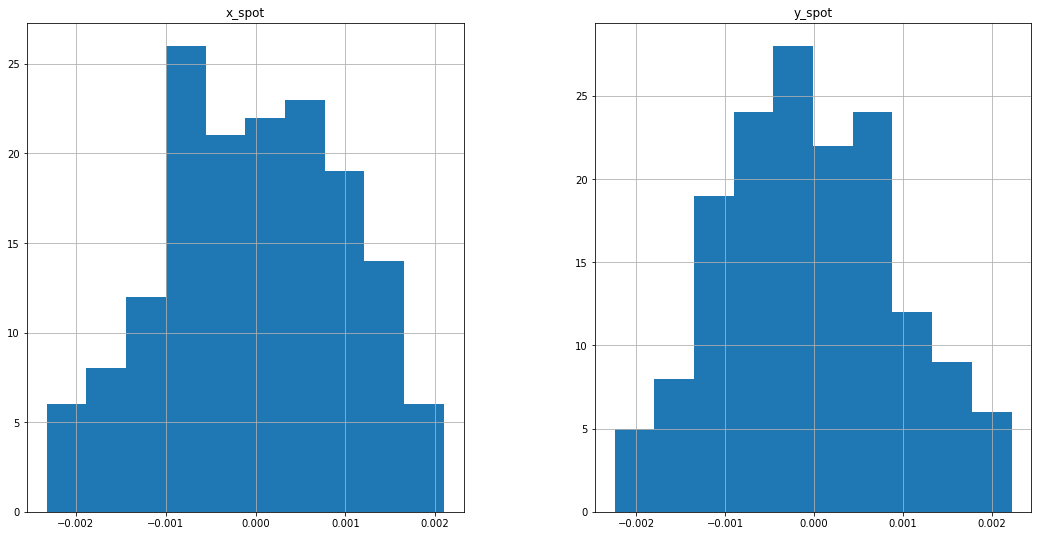

In [17]:
def plot_impact_point_residuals(imp):
    imp.hist(["x_spot", "y_spot"], figsize=(18, 9))
    print(f'x_spot is at {imp["x_spot"].mean()*1e6:.0f} +/- {imp["x_spot"].std()*1e6:.0f} mu (dist={imp["x_spot"].max()*1e6-imp["x_spot"].min()*1e6:.0f} mu)')
    print(f'y_spot is at {imp["y_spot"].mean()*1e6:.0f} +/- {imp["y_spot"].std()*1e6:.0f} mu (dist={imp["y_spot"].max()*1e6-imp["y_spot"].min()*1e6:.0f} mu)')

plot_impact_point_residuals(impacts_r22_s11)

<AxesSubplot: xlabel='wl', ylabel='x_spot'>

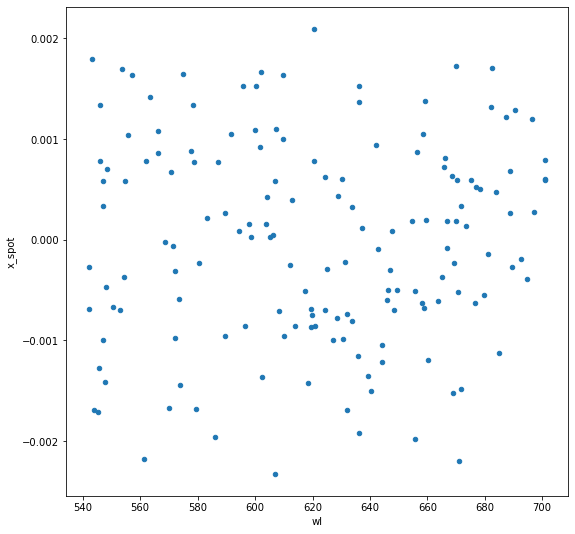

In [18]:
impacts_r22_s11.plot.scatter("wl", "x_spot")

<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

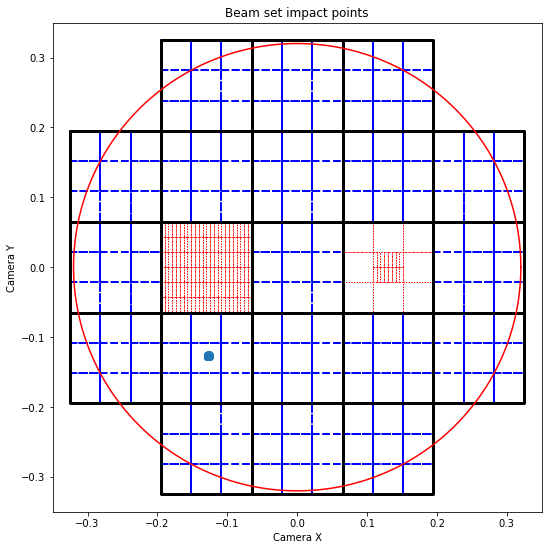

In [19]:
impacts_r11_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r11_s11_beam_set)
plotter.plot_impact_points_full_frame(impacts_r11_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

x_spot is at -126961 +/- 1009 mu (dist=4684 mu)
y_spot is at -126885 +/- 1020 mu (dist=4550 mu)


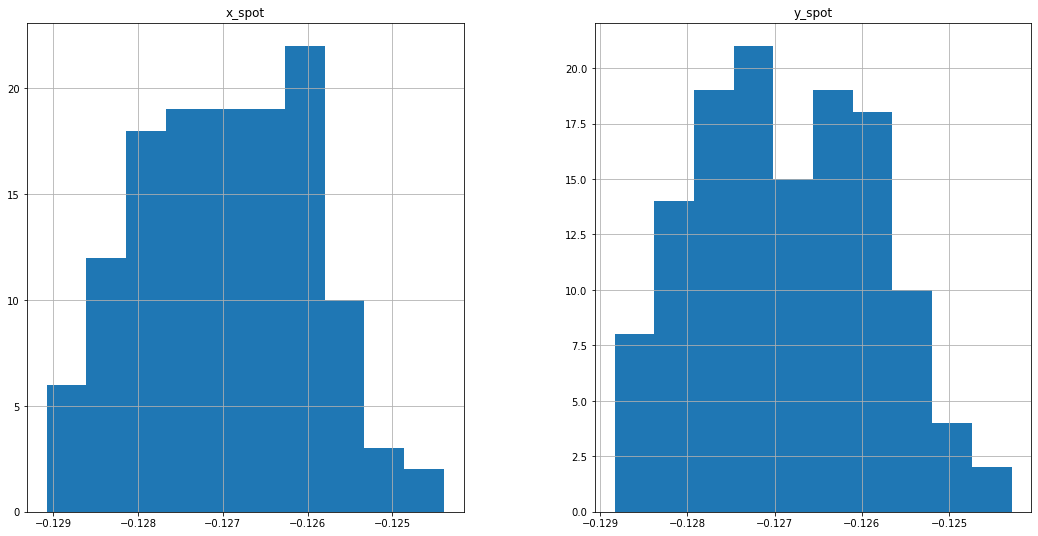

In [20]:
plot_impact_point_residuals(impacts_r11_s11)

<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

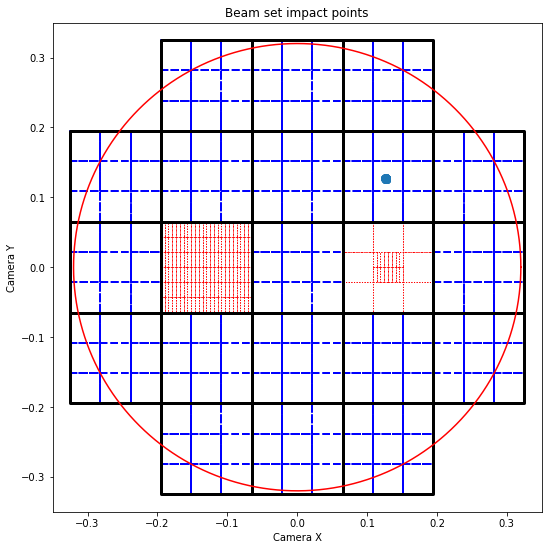

In [21]:
impacts_r33_s11 = simulator.simulate_impact_points_for_beam_set(telescope, r33_s11_beam_set)
plotter.plot_impact_points_full_frame(impacts_r33_s11)
camera = build_camera()
show_camera(plt.gca(), camera)

x_spot is at 127017 +/- 1068 mu (dist=4749 mu)
y_spot is at 126789 +/- 1023 mu (dist=4443 mu)


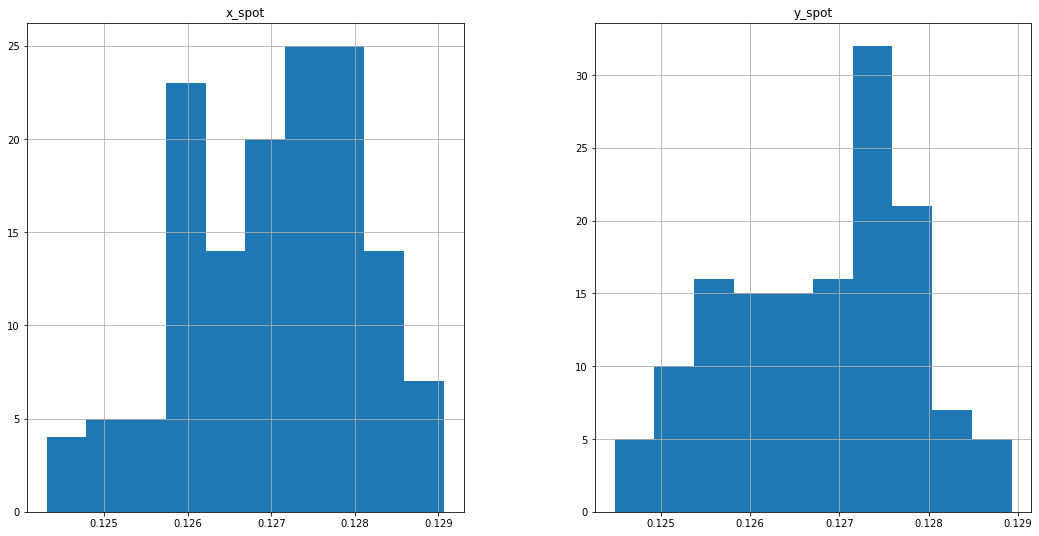

In [22]:
plot_impact_point_residuals(impacts_r33_s11)

## Now read the extracted set of configuration from the official configurations file

In [23]:
df_cfg = read_ccob_config_cfg('data/rband_step9_test_configs_20221130.txt')
df_cfg.head()

,CCOBBPOS,CCOBUPOS,CCOBXPOS,CCOBYPOS,darktime,expose,lambda,rebs,CCOBBCAM,CCOBUCAM,CCOBXCAM,CCOBYCAM,id,sens,target_phot_per_pix,total_phots
0,28.1894,134.6250,1448.644,1411.195,10.0,0.3912,542.0,R22/Reb1,18.1894,133.6250,274.82,288.34,9442238,R22_S11,70000.0,3.106700e+09
1,29.5603,103.1062,1253.291,1527.411,10.0,0.3944,542.0,R22/Reb1,19.5603,102.1062,90.34,421.14,9442265,R22_S11,70000.0,3.132200e+09
2,-8.4832,127.2036,990.070,753.394,10.0,0.4870,701.0,R22/Reb1,-18.4832,126.2036,-239.34,-326.99,9442293,R22_S11,70000.0,3.112200e+09
3,33.5112,74.4983,1006.698,1590.690,10.0,0.5037,701.0,R22/Reb1,23.5112,73.4983,-149.80,505.67,9442305,R22_S11,70000.0,3.218900e+09
4,-7.0013,161.5813,862.490,946.771,10.0,0.4829,701.0,R22/Reb1,-17.0013,160.5813,-349.58,-123.23,9442315,R22_S11,70000.0,3.086000e+09


In [24]:
# Select a bunch of interesting configuration
r22_s11_cfg = df_cfg[(df_cfg['sens']=="R22_S11")]
r22_s11_cfg.head(10)

,CCOBBPOS,CCOBUPOS,CCOBXPOS,CCOBYPOS,darktime,expose,lambda,rebs,CCOBBCAM,CCOBUCAM,CCOBXCAM,CCOBYCAM,id,sens,target_phot_per_pix,total_phots
0,28.1894,134.6250,1448.644,1411.195,10.0,0.3912,542.000,R22/Reb1,18.1894,133.6250,274.82,288.34,9442238,R22_S11,70000.0,3.106700e+09
1,29.5603,103.1062,1253.291,1527.411,10.0,0.3944,542.000,R22/Reb1,19.5603,102.1062,90.34,421.14,9442265,R22_S11,70000.0,3.132200e+09
2,-8.4832,127.2036,990.070,753.394,10.0,0.4870,701.000,R22/Reb1,-18.4832,126.2036,-239.34,-326.99,9442293,R22_S11,70000.0,3.112200e+09
3,33.5112,74.4983,1006.698,1590.690,10.0,0.5037,701.000,R22/Reb1,23.5112,73.4983,-149.80,505.67,9442305,R22_S11,70000.0,3.218900e+09
4,-7.0013,161.5813,862.490,946.771,10.0,0.4829,701.000,R22/Reb1,-17.0013,160.5813,-349.58,-123.23,9442315,R22_S11,70000.0,3.086000e+09
5,-10.3037,178.6999,755.105,1042.998,10.0,0.7921,659.288,R22/Reb1,-20.3037,177.6999,-448.17,-18.01,9442361,R22_S11,70000.0,3.147100e+09
6,24.5433,10.7285,886.588,1125.923,10.0,0.4179,554.615,R22/Reb1,14.5433,9.7285,-309.96,53.14,9442374,R22_S11,70000.0,3.048900e+09
7,-9.1242,134.0004,941.196,768.743,10.0,0.5043,587.004,R22/Reb1,-19.1242,133.0004,-286.69,-307.44,9442387,R22_S11,70000.0,3.123600e+09
8,-8.3036,25.6543,1577.653,965.121,10.0,0.5828,610.083,R22/Reb1,-18.3036,24.6543,364.46,-167.28,9442411,R22_S11,70000.0,3.108700e+09
9,29.9461,38.5857,829.308,1336.944,10.0,0.4331,555.812,R22/Reb1,19.9461,37.5857,-348.63,268.35,9442444,R22_S11,70000.0,3.139700e+09


In [25]:
# Map to a ghosts beam config
r22_s11_beam_set_cfg = build_beam_set_cfg(r22_s11_cfg)

In [26]:
r22_s11_beam_set_cfg[0]

{'beam_id': 9442238,
 'wl': 542.0,
 'n_photons': 1000,
 'radius': 0.00125,
 'x_offset': 0.27482,
 'y_offset': 0.28834,
 'z_offset': 3.195711882,
 'z_euler': 135.0930170603762,
 'y_euler': -12.772939514501296,
 'x_euler': 13.059508444047}

0

/home/bregeon/data/Soft/miniconda3/envs/ghosts/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


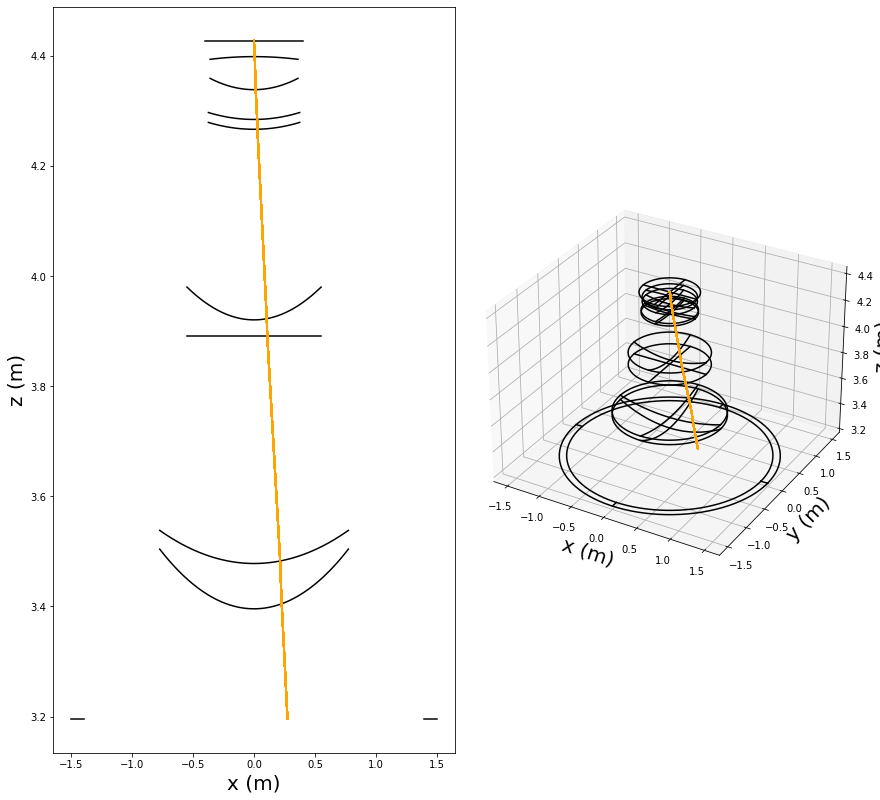

In [27]:
# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=r22_s11_beam_set_cfg[0])
#trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=test_conf)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup_3d(telescope, simulation)

In [28]:
impacts_r22_s11_cfg = simulator.simulate_impact_points_for_beam_set(telescope, r22_s11_beam_set_cfg)

In [29]:
impacts_r22_s11_cfg.head(20)

,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,x_spot,y_spot,beam_dist_to_center,spot_dist_to_center,convergence,displacement
9442238,9442238,542.000,1000,0.00125,0.27482,0.28834,3.195712,135.093017,-12.772940,13.059508,-0.000691,-0.000708,0.398329,0.000989,0.002484,-0.397340
9442265,9442265,542.000,1000,0.00125,0.09034,0.42114,3.195712,102.823800,-4.261564,19.108192,-0.000235,-0.001225,0.430721,0.001247,0.002895,-0.429474
9442293,9442293,701.000,1000,0.00125,-0.23934,-0.32699,3.195712,127.660880,11.168734,-14.821948,0.000627,0.000833,0.405224,0.001043,0.002574,-0.404181
9442305,9442305,701.000,1000,0.00125,-0.14980,0.50567,3.195712,72.096118,7.044430,22.488438,0.000586,-0.002063,0.527392,0.002144,0.004066,-0.525247
9442315,9442315,701.000,1000,0.00125,-0.34958,-0.12323,3.195712,161.370185,16.085569,-5.578632,0.000815,0.000255,0.370664,0.000854,0.002303,-0.369810
9442361,9442361,659.288,1000,0.00125,-0.44817,-0.01801,3.195712,177.842674,20.288676,-0.797937,0.001360,0.000039,0.448532,0.001360,0.003033,-0.447172
9442374,9442374,554.615,1000,0.00125,-0.30996,0.05314,3.195712,9.422461,14.342848,2.431948,0.000545,-0.000095,0.314482,0.000553,0.001759,-0.313929
9442387,9442387,587.004,1000,0.00125,-0.28669,-0.30744,3.195712,134.625148,13.305293,-13.863071,0.000788,0.000814,0.420369,0.001133,0.002694,-0.419237
9442411,9442411,610.083,1000,0.00125,0.36446,-0.16728,3.195712,23.545681,-16.732556,-7.527638,-0.000912,0.000404,0.401016,0.000997,0.002487,-0.400018
9442444,9442444,555.812,1000,0.00125,-0.34863,0.26835,3.195712,35.887037,16.044247,12.009567,0.001028,-0.000761,0.439948,0.001279,0.002906,-0.438670


<AxesSubplot: title={'center': 'Beam set impact points'}, xlabel='Camera X', ylabel='Camera Y'>

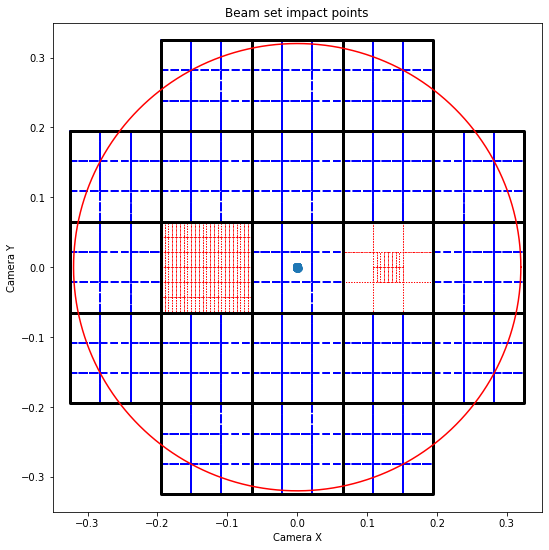

In [30]:
plotter.plot_impact_points_full_frame(impacts_r22_s11_cfg)
camera = build_camera()
show_camera(plt.gca(), camera)